<a href="https://colab.research.google.com/github/Chei-YuanChi/Segmentation_HW/blob/main/Segmentation_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt
import glob, cv2, os, sys

from tqdm import tqdm


float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Data

### Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Take a look

In [ ]:
# get fold_1 image and label files path

images = glob.glob('/content/drive/MyDrive/vertebral/data/f01/image/*.png')
labels = glob.glob('/content/drive/MyDrive/vertebral/data/f01/label/*.png')

images.sort(), labels.sort()

(None, None)

In [ ]:
images[0], labels[0]

('/content/drive/MyDrive/vertebral/data/f01/image/0001.png',
 '/content/drive/MyDrive/vertebral/data/f01/label/0001.png')

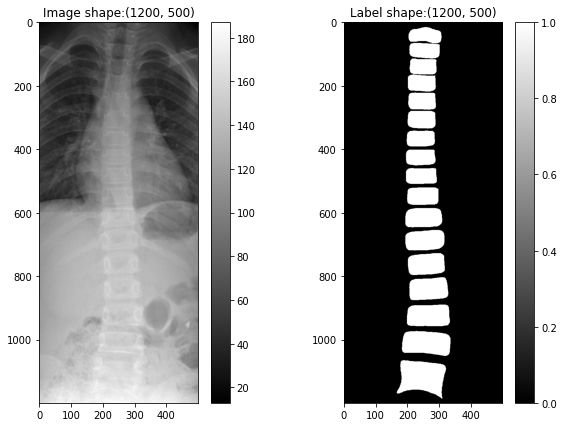

In [ ]:
plt.figure(figsize=(10, 7))

#plot images[0]
plt.subplot(1, 2, 1)
img = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = 'gray')
plt.title('Image shape:{}'.format(img.shape))
plt.colorbar()

#plot labels[0]
plt.subplot(1, 2, 2)
label = cv2.imread(labels[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(label / 255., cmap = 'gray')
plt.title('Label shape:{}'.format(label.shape))
plt.colorbar()


# U-Net Architecture

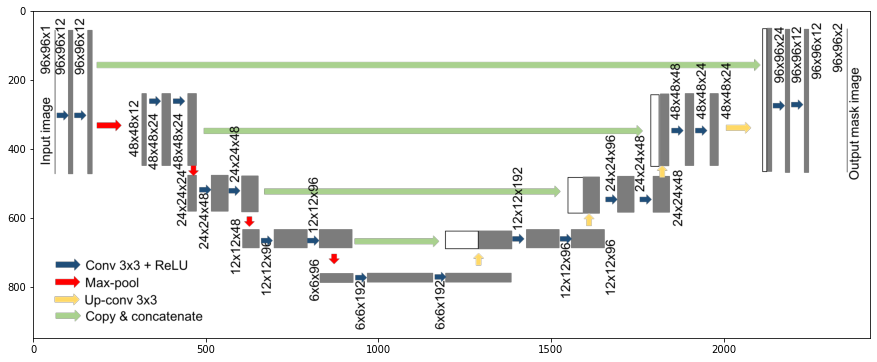

In [ ]:
plt.figure(figsize = (15, 15))
img = plt.imread('http://jidan.sinkpoint.com/images/True_Unet_MRI_deco.png')
plt.imshow(img)

# Part1. Build a simple model first

In [ ]:
"""
1.PyTorch中的nn.Module是構成模型的最基礎block，可以自行客製化。
2.nn.Module可以包含另一個nn.Module
3.nn.Module享有PyTorch的Autograd機制
4.每個nn.Module都有一個parameters() function, return a list of all trainable parameters
5.Module中的trainable parameters必須被事先定義在constructor內，否則不會存在於Computation graph中
"""

'''
aW+b

input: (1x2)
hidden_layer: (2x2)
output : (1x2) x (2x2) = activation((1x2))
'''

class MyModel(nn.Module):
  def __init__(self, dim = 2 , output_dim = 2):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(size = (dim, output_dim)))
    self.bias = nn.Parameter(torch.randn(output_dim))

    #or in this why : 
    self.linear = nn.Linear(in_features = dim, out_features = output_dim, bias = True)

    self.softmax = nn.Softmax(dim = 1)

  def forward(self, x):
    logit = x @ self.weights + self.bias # (1,2)
    y = self.softmax(logit)

    # Same as : y = F.softmax(logit, dim = 1)
    return y

In [ ]:
myModel = MyModel(dim = 2, output_dim = 2)

# myModel.forward(x)
pred = myModel(torch.randn(1, 2))

'''
1. detach() : 把node從computation graph移除 -> Tensor永遠不會計算gradient
2. cpu() : 從CUDA(GPU) memory移至cpu memory中存放
3. numpy(): 轉成numpy array
'''
pred = pred.detach().cpu().numpy()
print('Output shape: %s\n %s' %(pred.shape, pred)) 

Output shape: (1, 2)
 [[0.43 0.57]]


In [ ]:
print('List of parameters : \n{}\n'.format(list(myModel.parameters())))

List of parameters : 
[Parameter containing:
tensor([[ 1.0732,  0.5504],
        [ 2.2860, -0.5788]], requires_grad=True), Parameter containing:
tensor([-0.2495, -0.0908], requires_grad=True), Parameter containing:
tensor([[-0.0655,  0.3804],
        [ 0.1155, -0.6023]], requires_grad=True), Parameter containing:
tensor([-0.2965,  0.2136], requires_grad=True)]



### nn.Module v.s. nn.functionals

In [ ]:
data_x = torch.randn(size = (1, 2))

softmax1 = nn.Softmax(dim = 1)
softmax2 = F.softmax

print('nn.Moudle.Softmax : {}'.format(softmax1(data_x)))
print('nn.functional.softmax : {}'.format(softmax2(data_x, dim=1)))

nn.Moudle.Softmax : tensor([[0.2811, 0.7189]])
nn.functional.softmax : tensor([[0.2811, 0.7189]])


In [ ]:
'''
最大的不同在於：nn.functionals.xxx只有"計算功能"。
幾乎所有nn.Module.xxx的forward都是以nn.functional.xxx實作，weight都是用nn.Parameter
nn.Module擁有將parameter放入computation graph中利用Autograd機制進行訓練參數的功能

如何選擇？Statefulness

'''

data_x = torch.randn(size = (2, 2))
dim = 2
output_dim = 1

#宣告weights和bias給linear2使用
#linear2沒有parameters()這個function
weights = nn.Parameter(torch.randn(size = (output_dim, dim)))
bias = nn.Parameter(torch.randn(output_dim))
linear2 = F.linear

#nn.Linear的constructor會自動創建nn.Parameter和bias
#linear2有parameters()這個function
linear1 = nn.Linear(dim, output_dim)

print('nn.Moudle.Linear : {}'.format(linear1(data_x)))
print('nn.functional.linear : {}'.format(linear2(data_x, weights, bias)))

nn.Moudle.Linear : tensor([[-0.1088],
        [-0.4964]], grad_fn=<AddmmBackward>)
nn.functional.linear : tensor([[0.9466],
        [1.5580]], grad_fn=<AddmmBackward>)


### nn.Parameter

In [ ]:
'''
PyTorch中最重要的一個Class，沒有他其他nn.Module什麼都不是。
前面所看到的parameters() function，回傳的就是Module中所有nn.Parameter object。

nn.Parameter的一些重要特性：
1.繼承至Tensor class，其本質也就只是一個Tensor(高維的矩陣)
2.當被包含在某個Module的atrribute中，會自動被加入該Module的parameters list
3.可以把普通的Tensor轉成trainable的parameter
'''

class Net1(nn.Module):
  def __init__(self):
    super().__init__()
    self.tensor = torch.randn(size = (3, 3, 3))
  def forward(self):
    return self.tensor

net1 = Net1()
print('List of parameters: {}\n'.format(list(net1.parameters())))


class Net2(nn.Module):
  def __init__(self):
    super().__init__()
    self.tensor = nn.Parameter(torch.randn(size = (3, 3, 3)))
  def forward(self):
    return self.tensor

net2 = Net2()
print('List of parameters: {}'.format(list(net2.parameters())))

List of parameters: []

List of parameters: [Parameter containing:
tensor([[[ 1.2030, -0.8388,  0.6588],
         [-0.7349, -0.6873, -0.5442],
         [ 0.2997,  0.3830,  2.1859]],

        [[ 0.4261,  0.8118, -0.1392],
         [-0.8090, -0.6593, -1.4683],
         [-0.3569,  1.6464, -0.0316]],

        [[ 0.0114,  2.8380,  0.3674],
         [-0.9726,  0.4567, -1.2276],
         [-0.3978,  0.9792,  0.6199]]], requires_grad=True)]


In [ ]:
'''
Net1包含於Net2，則Net1的parameter會自動添加入Net2的parameter list中。
'''

class Net1(nn.Module):
  def __init__(self):
    super().__init__()
    self.tensor = nn.Parameter(torch.randn(size = (3, 3, 3)))
  def forward(self):
    return self.tensor

myNet = Net1()
print('List of parameters: {}\n'.format(list(myNet.parameters())))

class Net2(nn.Module):
  def __init__(self):
    super().__init__()
    self.tensor = nn.Parameter(torch.randn(1))
    self.net = Net1()
  def forward(self):
    return self.tensor

myNet = Net2()
print('List of parameters: {}'.format(list(myNet.parameters())))


List of parameters: [Parameter containing:
tensor([[[ 0.3773, -0.1368, -0.9696],
         [ 1.0657, -0.6356, -1.6065],
         [ 1.9910, -0.9102,  0.1760]],

        [[ 0.9793,  1.1404,  1.4930],
         [ 0.9924,  0.1133, -2.5625],
         [ 1.0246,  0.5355,  0.0839]],

        [[ 0.9296, -1.7517, -0.3771],
         [-0.2560,  0.3240,  0.0847],
         [ 0.3410, -0.8483,  1.1551]]], requires_grad=True)]

List of parameters: [Parameter containing:
tensor([2.1013], requires_grad=True), Parameter containing:
tensor([[[-1.2892,  1.0250, -0.0463],
         [-0.1559,  0.1723,  0.4703],
         [-0.5044, -0.9363,  0.6778]],

        [[-0.0749, -0.9521,  0.9781],
         [ 1.7874,  0.2483,  0.3014],
         [-0.5918, -0.0254, -0.3306]],

        [[ 1.2684,  0.6967, -1.5885],
         [-1.4773,  1.4961, -1.3760],
         [ 0.0813,  0.4538, -0.9458]]], requires_grad=True)]


# Part2.Simple U-Net model

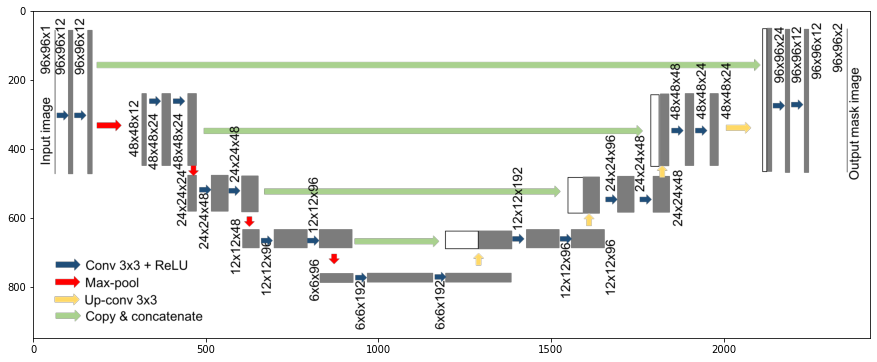

In [ ]:
plt.figure(figsize = (15, 15))
img = plt.imread('http://jidan.sinkpoint.com/images/True_Unet_MRI_deco.png')
plt.imshow(img)

In [ ]:
class conv3x3_bn_relu(nn.Module):
  def __init__(self, inplanes, kernels, stride, padding = 1):
    super().__init__()

    self.sequence = nn.Sequential(
      nn.Conv2d(inplanes, kernels, kernel_size = 3, stride = stride, padding = padding),
      nn.BatchNorm2d(num_features = kernels),
      nn.ReLU(inplace = True)  
    )

  def forward(self, x):
  
    return self.sequence(x)

In [ ]:
class SELayer(nn.Module):
  def __init__(self, inplanes, kernels, stride, padding, reduction=16):
    super(SELayer, self).__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.conv = nn.Sequential(
      conv3x3_bn_relu(inplanes, kernels, stride, padding),
      conv3x3_bn_relu(kernels, kernels, stride, padding),
    )   
    self.fc = nn.Sequential( 
      nn.Linear(kernels, kernels // reduction, bias=False), 
      nn.ReLU(inplace=True),    
      nn.Linear(kernels // reduction, kernels, bias=False),  
      nn.Sigmoid()
    )

  def forward(self, input):
    x = self.conv(input)
    b, c, _, _ = x.size()
    y = self.avg_pool(x).view(b, c) 
    y = self.fc(y).view(b, c, 1, 1)
    return x * y.expand_as(x) + input

In [ ]:
class down(nn.Module):
  def __init__(self, inplanes, kernels, stride, padding = 1, reduction = 16, pooling = True):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(inplanes, kernels, kernel_size = 3, stride = stride, padding = padding),
        SELayer(kernels, kernels, stride, padding, reduction),
        SELayer(kernels, kernels, stride, padding, reduction),
    )
    self.max_pooling = nn.MaxPool2d(2) if pooling else nn.Identity()
    
  def forward(self, x):
    return self.max_pooling(self.conv(x))

In [ ]:
class up(nn.Module):
  def __init__(self, inplanes, kernels, stride = 1, padding = 1, bilinear = True):
    super().__init__()
    if bilinear :
      self.up = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners = True)
      self.conv = nn.Sequential(
        conv3x3_bn_relu(inplanes + inplanes // 2, kernels, stride, padding),
        conv3x3_bn_relu(kernels, kernels, stride, padding),
      ) 
      # self.conv = nn.ModuleList([
      #   conv3x3_bn_relu(inplanes + inplanes // 2, kernels, stride, padding),
      #   conv3x3_bn_relu(kernels, kernels, stride, padding),                            
      # ])
    else:
      self.up = nn.ConvTranspose2d(inplanes, inplanes//2, kerenls_size = 2, stride = stride)
      
      self.conv = nn.Sequential(
        conv3x3_bn_relu(inplanes, kernels, stride, padding),
        conv3x3_bn_relu(kernels, kernels, stride, padding),
      ) 
  def forward(self, x1, x2):
    x2 = self.up(x2)
    return self.conv(torch.cat([x1, x2], dim = 1))

In [ ]:
class Unet(nn.Module):
  def __init__(self, n_channel = 1, n_class = 1, bilinear = True):
    super().__init__()
    self.down1 = down(n_channel, 12, 1, pooling = False)
    self.down2 = down(12, 24, 1)
    self.down3 = down(24, 48, 1)
    self.down4 = down(48, 96, 1)
    self.down5 = down(96, 192, 1)
    self.up1 = up(96*2, 96, 1, bilinear = bilinear)
    self.up2 = up(48*2, 48, 1, bilinear = bilinear)
    self.up3 = up(24*2, 24, 1, bilinear = bilinear)
    self.up4 = up(12*2, 12, 1, bilinear = bilinear)
    self.out = nn.Conv2d(12, n_class, 3, 1, padding = 1)
  def forward(self, x):
    x1 = self.down1(x)
    x2 = self.down2(x1)
    x3 = self.down3(x2)
    x4 = self.down4(x3)
    x5 = self.down5(x4)
    x = self.up1(x4, x5)
    x = self.up2(x3, x)
    x = self.up3(x2, x)
    x = self.up4(x1, x)
    logit = self.out(x)
    return logit

### nn.Sequential v.s. nn.ModuleList

In [ ]:
'''
nn.Sequential: 屬於nn.Module class，可以把一連串的nn.Module彼此chain在一起。無法改變這些Module的執行順序
nn.ModuleList: 類似python內建的list，只是裡面是裝nn.Module。同list可以用indexing的方式決定使用哪個nn.Module
'''
class sequentialNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.modules = nn.Sequential(
        nn.Linear(10, 10),
        nn.Linear(10, 2)
    )

  def forward(self, x):
    return self.modules(x)


class moduleListNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.modules = nn.ModuleList([
        nn.Linear(10, 10),
        nn.Linear(10, 2)
    ])

  def forward(self, x):
    for i in range(len(self.modules)):
      x = self.modules[i](x)
    return x

In [ ]:
'''
nn.ModuleList與python中list唯一的不同在於，nn.ModuleList才會將nn.Module中的parameter註冊到Module的parameters list。一般的list則否
'''

class moduleListNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.modules = nn.ModuleList([
        nn.Linear(10, 10),
        nn.Linear(10, 2)
    ])

  def forward(self, x):
    for m in self.modules:
      x = m(x)
    return x

class standardListNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.modules = [
        nn.Linear(10, 10),
        nn.Linear(10, 2)
    ]

  def forward(self, x):
    for m in self.modules:
      x = m(x)
    return x

mlNet = moduleListNet()
slNet = standardListNet()
print('List of parameters: {}\n'.format(list(mlNet.parameters())))
print('List of parameters: {}'.format(list(slNet.parameters())))

List of parameters: [Parameter containing:
tensor([[ 0.0186, -0.2109, -0.1516, -0.3063,  0.1646, -0.2622,  0.0569, -0.0126,
         -0.2353,  0.1048],
        [ 0.0699, -0.0932, -0.0576, -0.0013,  0.1327,  0.2719,  0.1945, -0.2149,
          0.2564,  0.1391],
        [ 0.1173, -0.3052,  0.0501, -0.1998, -0.0840,  0.3146,  0.2127,  0.2882,
          0.2225, -0.0533],
        [-0.0352,  0.1903,  0.2669, -0.2599,  0.1498,  0.0468, -0.0232, -0.0433,
          0.1188, -0.0647],
        [ 0.1777, -0.2814,  0.1596, -0.2184, -0.0810, -0.0928,  0.2990, -0.0854,
          0.1024, -0.0851],
        [ 0.0292, -0.2288,  0.1572,  0.1022,  0.2793, -0.2544, -0.1926,  0.1661,
          0.2355, -0.2447],
        [ 0.2089, -0.2017,  0.1687,  0.0382,  0.2974, -0.2675,  0.1268,  0.0447,
          0.2288,  0.1021],
        [ 0.2235,  0.0363,  0.1195, -0.2710,  0.3110,  0.2253, -0.2610, -0.0104,
          0.1512, -0.1408],
        [-0.0240,  0.0510,  0.2562,  0.2263,  0.0772,  0.1253,  0.1023, -0.2087,
    

In [ ]:
unet = Unet()

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
output = unet(torch.randn(size = (1, 1, 1216, 512))) #(b, c, h, w)
print(output.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 1, 1216, 512])


# Part3. Dataset & Dataloader

### Dataset

#### Example 1

In [ ]:
'''
torchvision有提供很多跟影像相關的Dataset class
只不過這邊我們學怎麼根據自己的資料自定義自己的Dataset class :)
'''

from torch.utils.data import Dataset

In [ ]:
images[0], labels[0]

('/content/drive/MyDrive/vertebral/data/f01/image/0001.png',
 '/content/drive/MyDrive/vertebral/data/f01/label/0001.png')

In [ ]:
class SimpleImageDataset(Dataset):
  def __init__(self, images, labels):
    super().__init__()
    self.images = images
    self.labels = labels

  # 讓這個class可以用indexing的方式取東西
  # magic method
  def __getitem__(self, index):

    # get path
    img = self.images[index]
    label = self.labels[index]

    # read image
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)

    # 增加channel這個維度
    img = img[:,:,np.newaxis]
    label = label[:,:,np.newaxis]

    return img, label
  
  def __len__(self):
    #有多少筆數的資料
    return len(self.images)

In [ ]:
mDataset = SimpleImageDataset(images, labels)
len(images) == len(mDataset)

True

In [ ]:
img, label = mDataset[15]

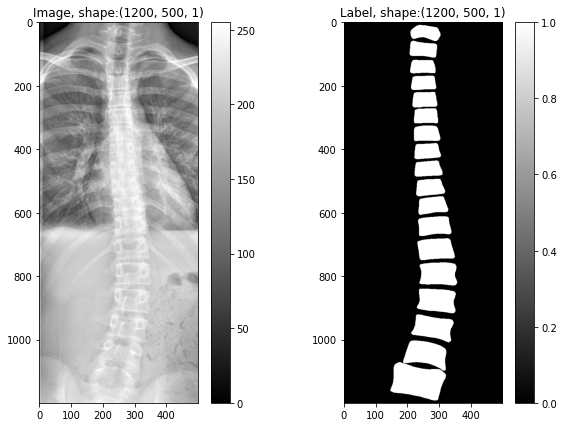

In [ ]:
plt.figure(figsize=(10, 7))

#plot images[0]
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(2), cmap = 'gray')
plt.title('Image, shape:{}'.format(img.shape))
plt.colorbar()

#plot labels[0]
plt.subplot(1, 2, 2)
plt.imshow(label.squeeze(2) / 255., cmap = 'gray')
plt.title('Label, shape:{}'.format(label.shape))
plt.colorbar()


#### Example 2

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/My Drive/vertebral/example.csv')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.iloc[:,2:]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,211536,13.0000,NaN,S
887,1,female,19.0,0,0,112053,30.0000,B42,S
888,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
titanic_data = df.iloc[:,2:].to_numpy()
titanic_labels = df['Survived'].tolist()

In [ ]:
titanic_data[0], titanic_labels[0]

(array([3, 'male', 22.0, 1, 0, 'A/5 21171', 7.25, nan, 'S'], dtype=object), 0)

In [ ]:
class TitanicDataset(Dataset):
  def __init__(self, data, labels):
    super().__init__()
    self.data = data
    self.labels = labels
  def __getitem__(self, index):
    
    data = self.data[index]
    labels = self.labels[index]

    '''
      Data preporcessing here
    '''

    return data, labels
  
  def __len__(self):
    #有多少筆數的資料
    return len(self.data)

In [ ]:
titanicDataset = TitanicDataset(titanic_data, titanic_labels)
titanicDataset[0]

(array([3, 'male', 22.0, 1, 0, 'A/5 21171', 7.25, nan, 'S'], dtype=object), 0)

### Dataloader

In [ ]:
'''
Dataloader可以視為Dataset的迭代器，主要包含兩個東東：
1.Dataset
2.Sampler -> 產生index


幾個比較重要的參數:
1.batch_size: 一次load多少份資料
2.shuffle: 每次把所有資料都load過一遍之後，是否要不要shuffle新一輪的順序。
shuffle = True -> default RandomSampler; shuffle = False -> default SequentialSampler

3.num_workers: 執行緒數量，加快資料的載入
4.pin_memory: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
5.drop_last: 最後一個batch的資料數量若小於batch_size，是否略過
'''

from torch.utils.data import DataLoader

In [ ]:
mDataloader = DataLoader(dataset = mDataset, batch_size = 10, shuffle = True, num_workers = 4, drop_last = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
mDataloader_iter = iter(mDataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(mDataloader_iter)
print(data[0].shape, data[1].shape) # (b, h, w, c) torch:(b, c, w, h)

torch.Size([10, 1200, 500, 1]) torch.Size([10, 1200, 500, 1])


# Part4. Training pipeline

### Augmentation

In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 3.4 MB/s 
     |████████████████████████████████| 37.1 MB 51 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_simple_training_augmetation():
  aug = [
         albu.Flip(p = 0.5),
         albu.ShiftScaleRotate(shift_limit = 0.1, rotate_limit= 30, border_mode=cv2.BORDER_CONSTANT, p = 0.8),
         albu.PadIfNeeded(1216, 512, always_apply = True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask = True)
  ]
  return albu.Compose(aug)

def get_validation_augmentation():
  aug = [
         albu.PadIfNeeded(1216, 512, always_apply = True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask = True) 
  ]
  return albu.Compose(aug)

In [ ]:
class AugmentedImageDataset(Dataset):
  def __init__(self, images, labels, augmentation = None):
    super().__init__()
    self.images = images
    self.labels = labels
    self.augmentation = augmentation
  def __getitem__(self, index):

    # get path
    img = self.images[index]
    label = self.labels[index]

    # read image
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)

    # 增加channel這個維度
    img = img[:,:,np.newaxis]
    label = label[:,:,np.newaxis]

    # Augmentation
    if(self.augmentation):
      sampled = self.augmentation(image = img, mask = label)
      img = sampled['image']
      label = sampled['mask']


    return torch.div(img, 255), torch.div(label, 255)
  
  def __len__(self):
    #有多少筆數的資料
    return len(self.images)

In [ ]:
mDataset = AugmentedImageDataset(images, labels, augmentation = get_simple_training_augmetation())

In [ ]:
img, label = mDataset[0]

img.shape, label.shape

(torch.Size([1, 1216, 512]), torch.Size([1, 1216, 512]))

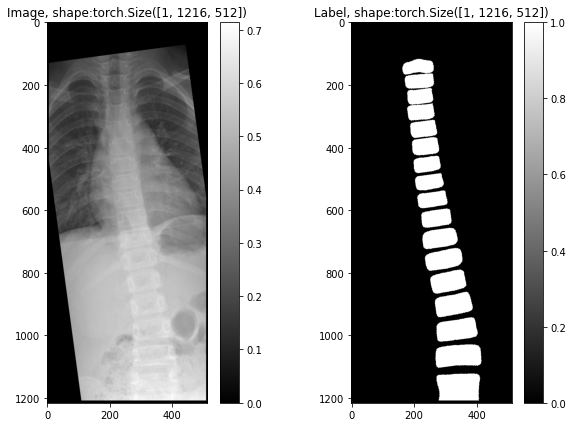

In [ ]:
plt.figure(figsize=(10, 7))

#plot images[0]
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(0), cmap = 'gray')
plt.title('Image, shape:{}'.format(img.shape))
plt.colorbar()

#plot labels[0]
plt.subplot(1, 2, 2)
plt.imshow(label.squeeze(0), cmap = 'gray')
plt.title('Label, shape:{}'.format(label.shape))
plt.colorbar()


In [ ]:
def get_complex_training_augmetation():
  aug = [
         albu.Flip(p = 0.5),
         albu.ShiftScaleRotate(shift_limit = 0.1, rotate_limit= 30, border_mode=cv2.BORDER_CONSTANT, p = 0.8),

         albu.OneOf([
            albu.ElasticTransform(p = 0.8),
            albu.GridDistortion(p = 0.5)
         ], p = 0.8),

        albu.OneOf([
           albu.IAAAdditiveGaussianNoise(p=0.9),
           albu.GaussNoise(p=0.6),
       ], p = 0.8),
               
         albu.PadIfNeeded(1216, 512, always_apply = True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask = True)
  ]
  return albu.Compose(aug)

In [ ]:
mDataset = AugmentedImageDataset(images, labels, augmentation = get_complex_training_augmetation())

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


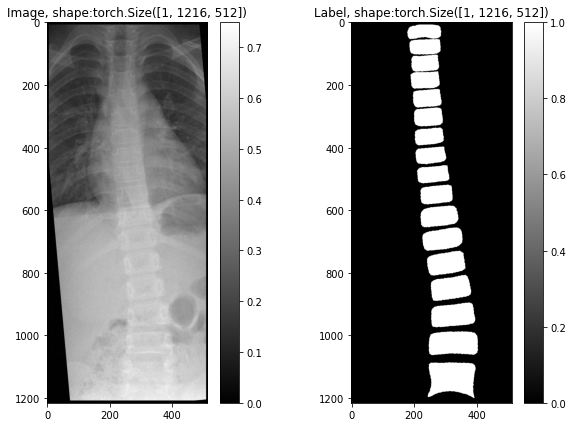

In [ ]:
img, label = mDataset[0]

plt.figure(figsize=(10, 7))

#plot images[0]
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(0), cmap = 'gray')
plt.title('Image, shape:{}'.format(img.shape))
plt.colorbar()

#plot labels[0]
plt.subplot(1, 2, 2)
plt.imshow(label.squeeze(0), cmap = 'gray')
plt.title('Label, shape:{}'.format(label.shape))
plt.colorbar()


### Training Setting

In [ ]:
class Dice(nn.Module):
  def __init__(self, eps = 1e-7, threshold = 0.5):
    super().__init__()
    self.eps = eps
    self.threshold = threshold
    self.activation = torch.sigmoid

  @property
  def __name__(self):
    return 'Dice'

  def _threshold(self, x):
    return (x > self.threshold).type(x.dtype)

  def forward(self, y_pr, y_gt):

    y_pr = self.activation(y_pr)
    y_pr = self._threshold(y_pr)

    tp = torch.sum(y_gt * y_pr)
    fp = torch.sum(y_pr) - tp
    fn = torch.sum(y_gt) - tp

    score = torch.div((2 * tp + self.eps), (2 * tp +  fn + fp + self.eps))
    return score  

class AverageValueMeter(object):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n = 1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 1:
            self.mean = 0.0 + self.sum 
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

def to_string(logs):
  str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
  s = ', '.join(str_logs)
  return s

In [ ]:
epochs = 60
lr = 5e-5
weight_decay = 1e-5
kfold = 3
save_path = '/content/drive/MyDrive/vertebral/weight'

bce_loss = nn.BCEWithLogitsLoss()
metric = Dice()
optimizer = torch.optim.Adam

device = 'cuda' if torch.cuda.is_available else 'cpu'

batch_size = 4
num_workers = 2
shuffle = True
drop_last = True
pin_memory = True


### Training & Validation

In [ ]:
def get_train_valid_data(fold):

    train_images = glob.glob('/content/drive/MyDrive/vertebral/data/f0{}/image/*.png'.format((fold+1)%3+1)) +\
                  glob.glob('/content/drive/MyDrive/vertebral/data/f0{}/image/*.png'.format((fold+2)%3+1))

    train_labels = glob.glob('/content/drive/MyDrive/vertebral/data/f0{}/label/*.png'.format((fold+1)%3+1)) +\
                  glob.glob('/content/drive/MyDrive/vertebral/data/f0{}/label/*.png'.format((fold+2)%3+1))

    valid_images = glob.glob('/content/drive/MyDrive/vertebral/data/f0{}/image/*.png'.format(fold%3+1))
    valid_labels = glob.glob('/content/drive/MyDrive/vertebral/data/f0{}/label/*.png'.format(fold%3+1))
    

    train_images.sort()
    train_labels.sort()
    valid_images.sort()
    valid_labels.sort()

    return (train_images, train_labels), (valid_images, valid_labels)

In [ ]:
k_fold_best = [0] * kfold


for fold in range(kfold):

  (train_images, train_labels), (valid_images, valid_labels) = get_train_valid_data(fold)
  
  train_dataset = AugmentedImageDataset(train_images, train_labels, get_complex_training_augmetation())
  valid_dataset = AugmentedImageDataset(valid_images, valid_labels, get_validation_augmentation())
  train_loader = DataLoader(train_dataset, batch_size, shuffle, num_workers = num_workers, pin_memory = pin_memory)
  valid_loader = DataLoader(valid_dataset, batch_size, shuffle, num_workers = num_workers, pin_memory = pin_memory)

  seg_model = Unet(n_channel = 1)
  opt = optimizer(seg_model.parameters(), lr = lr, weight_decay = weight_decay)
  seg_model.to(device)
  metric.to(device)
  
  model_name = os.path.join(save_path, str(fold+1), 'Unet.h5')

  max_score = 0

  for epoch in range(epochs):
    print('Epoch: %d' %(epoch+1))

    #training phase
    seg_model.train() #!!!!非常重要!!!!
    
    train_logs = {}
    loss_meter = AverageValueMeter()
    metric_meter = AverageValueMeter()
    with tqdm(train_loader, desc = 'Train', file = sys.stdout) as iterator:
      for imgs, gts in iterator:
        
        imgs = imgs.to(device, dtype = torch.float)#input記得要跟model在同一個device上
        gts = gts.to(device, dtype = torch.float)
        preds = seg_model(imgs)
        loss = bce_loss(preds, gts)

        #計算gradient
        loss.backward()
        #根據gradient和lr等等更新網路權重
        opt.step()
        #記得清零，否則會保留上一個batch的grad
        opt.zero_grad()

        loss_val = loss.cpu().detach().numpy()
        loss_meter.add(loss_val)
        train_logs.update({'CrossEntropy': loss_meter.mean})

        metric_val = metric(preds, gts).cpu().detach().numpy()
        metric_meter.add(metric_val)
        train_logs.update({metric.__name__: metric_meter.mean})

        iterator.set_postfix_str(to_string(train_logs))


    #validation phase
    seg_model.eval() #!!!!非常重要!!!!
    
    val_logs = {}
    loss_meter = AverageValueMeter()
    metric_meter = AverageValueMeter()
    with tqdm(valid_loader, desc = 'Valid', file = sys.stdout) as iterator:
      for imgs, gts in iterator:
        with torch.no_grad(): #!!!不算gradient!!!
        
          imgs = imgs.to(device, dtype = torch.float)
          gts = gts.to(device, dtype = torch.float)
          preds = seg_model(imgs)
          loss = bce_loss(preds, gts)

        loss_val = loss.cpu().detach().numpy()
        loss_meter.add(loss_val)
        val_logs.update({'CrossEntropy': loss_meter.mean})

        metric_val = metric(preds, gts).cpu().detach().numpy()
        metric_meter.add(metric_val)
        val_logs.update({metric.__name__: metric_meter.mean})

        iterator.set_postfix_str(to_string(val_logs))


    if max_score < val_logs['Dice']:
      max_score = val_logs['Dice'];
      k_fold_best[fold] = val_logs['Dice']

      torch.save(seg_model.state_dict(), model_name)
      print('Model Save !!!!')

print('\n')
print('K-Fold average Dice : %0.4f' %(sum(k_fold_best) / len(k_fold_best)))



/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 1
Valid: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it, CrossEntropy - 0.6835, Dice - 2.534e-13]
Model Save !!!!
Epoch: 2
Valid: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it, CrossEntropy - 0.6785, Dice - 2.447e-13]
Epoch: 3
Valid: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it, CrossEntropy - 0.6078, Dice - 2.509e-13]
Epoch: 4
Valid: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it, CrossEntropy - 0.5031, Dice - 2.499e-13]
Epoch: 5
Valid: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it, CrossEntropy - 0.5257, Dice - 0.0003936]
Model Save !!!!
Epoch: 6
Valid: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it, CrossEntropy - 0.5153, Dice - 0.009178]
Model Save !!!!
Epoch: 7
Valid: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it, CrossEntropy - 0.4711, Dice - 0.1882]
Model Save !!!!
Epoch: 8
Valid: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it, CrossEntropy - 0.4469, Dice - 0.2167]
Model Save !!!!
Epoch: 9
Valid: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it, CrossEntropy - 0.4987, Dice - 0.4041]
Mod

# Par5. Visualising Activations

### Prediction

In [ ]:
images = glob.glob('/content/drive/MyDrive/vertebral/data/f01/image/*.png')
labels = glob.glob('/content/drive/MyDrive/vertebral/data/f01/label/*.png')
images.sort(), labels.sort()

valid_dataset = AugmentedImageDataset(images, labels, get_validation_augmentation())

In [ ]:
# Load pre-trained weights
seg_model = Unet(1)
seg_model.eval()
seg_model.load_state_dict(torch.load('/content/drive/MyDrive/vertebral/weight/1/Unet.h5'))

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


<All keys matched successfully>

In [ ]:
with torch.no_grad():
  img, label = valid_dataset[11]
  pred = seg_model(img.unsqueeze(0))
  pred = torch.sigmoid(pred).detach().numpy()
  pred = np.where(pred > 0.5, 1, 0)

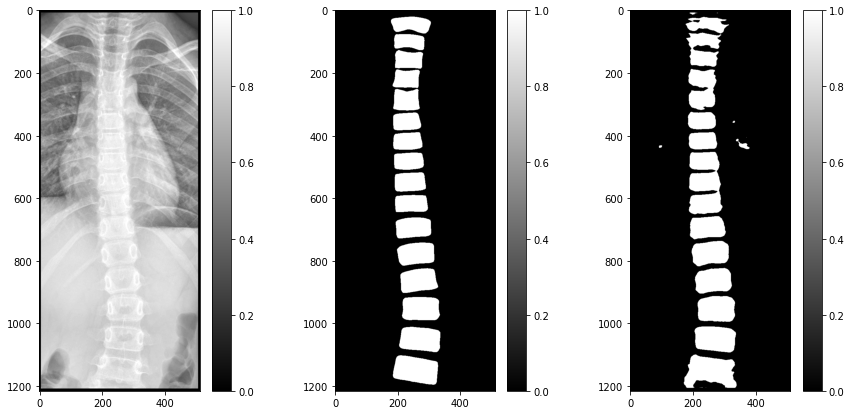

In [ ]:
plt.figure(figsize=(15, 7))

#plot input img
plt.subplot(1, 3, 1)
plt.imshow(img.squeeze(0), cmap = 'gray')
plt.colorbar()

#plot label
plt.subplot(1, 3, 2)
plt.imshow(label.squeeze(0), cmap = 'gray')
plt.colorbar()

#plot pred
plt.subplot(1, 3, 3)
plt.imshow(pred.squeeze((0, 1)), cmap = 'gray')
plt.colorbar()


### Hook

In [ ]:
'''
Pytorch包含forward以及backward兩種Hook，可用來取得forward和backward的輸入及輸出
好處是可不改變模型的任何架構以及不用在模型的forward或backward中寫一堆return，進而得到想要的數值
'''


def feature_map_hook(model, module, dataset, index):
  visualization = {}
  def hook_fn(m, i, o):
    visualization[m] = o.detach().cpu().numpy()

  # register hook after forward
  handler = module.register_forward_hook(hook_fn)

  model.eval()
  with torch.no_grad():
    img, label = dataset[index]
    pred = model(img.unsqueeze(0))

  #記得要remove掉
  handler.remove()

  return visualization

#### High-level

In [ ]:
visualization = feature_map_hook(seg_model, seg_model.down5, valid_dataset, 11)

In [ ]:
feature_map = list(visualization.values())[0]
print(feature_map.shape)
feature_map = feature_map.squeeze(0)

(1, 192, 76, 32)


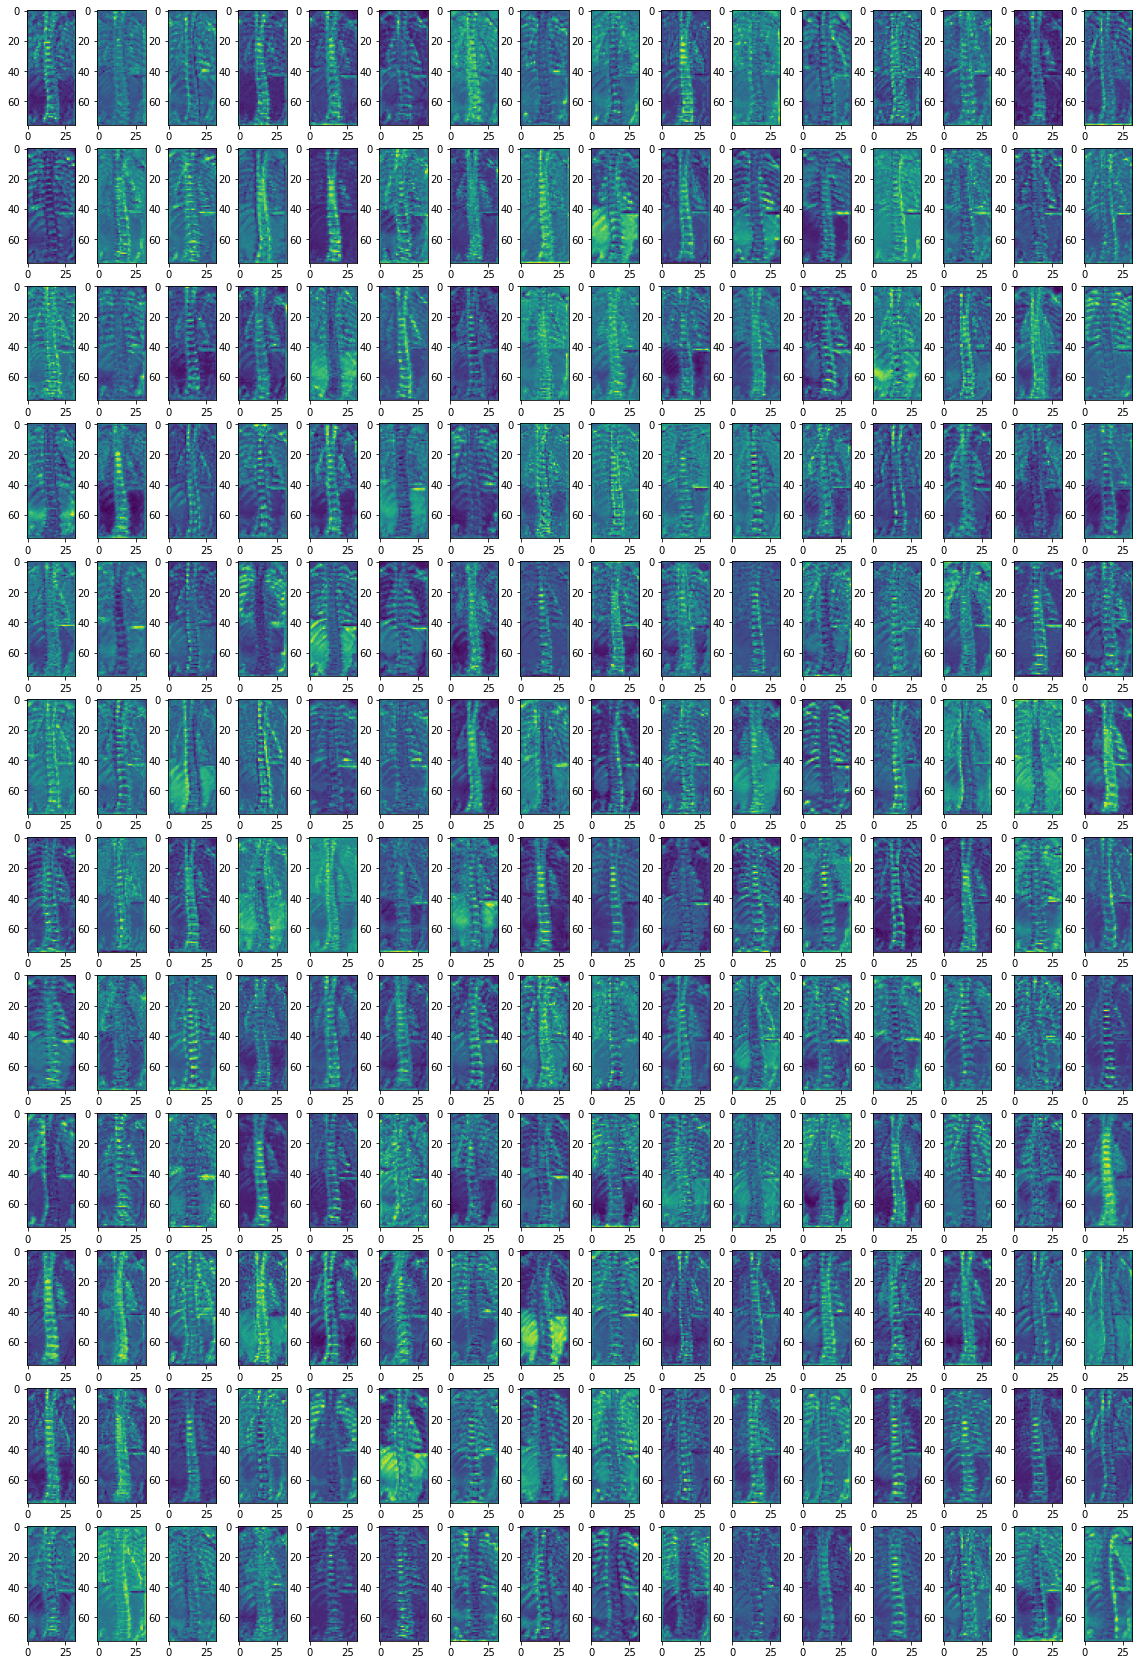

In [ ]:
plt.figure(figsize=(20, 30))

for i in range(192):
  plt.subplot(12, 16, i + 1)
  plt.imshow(feature_map[i])

#### Low-level

In [ ]:
visualization = feature_map_hook(seg_model, seg_model.down1, valid_dataset, 11)

In [ ]:
feature_map = list(visualization.values())[0]
print(feature_map.shape)
feature_map = feature_map.squeeze(0)

(1, 12, 1216, 512)


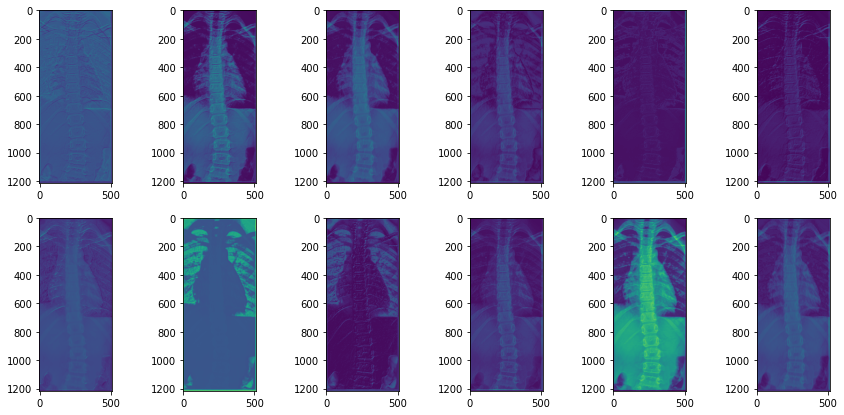

In [ ]:
plt.figure(figsize=(15, 7))

for i in range(12):
  plt.subplot(2, 6, i + 1)
  plt.imshow(feature_map[i])

# Part6. Autograd Mechanism

In [ ]:
'''
幾乎每個DL framework都有自己的自動偏微分的engine。PyTorch中稱做Autograd。

權重的更新涉及兩個階段: Forward和Backward
'''

a = torch.randn((3,3), requires_grad = True)

w1 = torch.randn((3,3), requires_grad = True)
w2 = torch.randn((3,3), requires_grad = True)
w3 = torch.randn((3,3), requires_grad = True)
w4 = torch.randn((3,3), requires_grad = True)

b = w1*a
b.retain_grad()
c = w2*a

d = w3*b + w4*c 

L = (10 -d).sum()

L.backward()

print('a.grad:{}\n'.format(a.grad))
print('b.grad:{}'.format(b.grad))

a.grad:tensor([[ 0.8577,  0.1955,  0.7510],
        [-1.8780,  0.2104,  0.0119],
        [-0.2132, -2.2157, -1.5240]])

b.grad:tensor([[-0.2220, -1.1309, -0.4249],
        [-1.6795, -0.6278, -0.4522],
        [-0.0702,  1.5463,  0.6929]])


### Computation Graphs

In [ ]:
'''
當model層數增加，參數變多時，手動計算每個weight對於loss的影響變得很不切實際。
為此PyTorch設計了一個資料結構:Computation Graphs(有向無環圖)

!!!圖中的node是operator!!!
'''

'\n當model層數增加，參數變多時，手動計算每個weight對於loss的影響變得很不切實際。\n為此PyTorch設計了一個資料結構:Computation Graphs(有向無環圖)\n\n!!!圖中的node是operator!!!\n'

#### Forward

![](https://blog.paperspace.com/content/images/2019/03/computation_graph.png)


#### Backward

![](https://blog.paperspace.com/content/images/2019/03/full_graph.png)


### What is requires_grad

In [ ]:
'''
顧名思義就是要設定哪些tensor需要計算gradient哪些不需要。->可以freeze模型某一部份使其不被更新
有幾點需要注意:
1.nn.Parameter是預設True。此外，一般create出來的Tensor預設是False。
2.requires_grad是會傳染的。
3.如果一個tensor的requires_grad=True，那它會有一個attribute叫做grad_fn
4.如果一個tensor在Computation graph中是leaf，那麼他的grad_fn是None
5.通常leaf node就是模型的parameter，是需要被update的。
'''


a = torch.randn((3,3), requires_grad = True)

w1 = torch.randn((3,3), requires_grad = True)
w2 = torch.randn((3,3), requires_grad = True)
w3 = torch.randn((3,3), requires_grad = True)
w4 = torch.randn((3,3), requires_grad = True)

b = w1*a 
c = w2*a

d = w3*b + w4*c 

L = 10 - d 

print("The grad fn for a is", a.grad_fn)
print("The grad fn for w1 is", w1.grad_fn)
print("The grad fn for c is", c.grad_fn)
print("The grad fn for d is", d.grad_fn)

The grad fn for a is None
The grad fn for w1 is None
The grad fn for c is <MulBackward0 object at 0x7f6cce1044d0>
The grad fn for d is <AddBackward0 object at 0x7f6cce104810>


### Pseudo code

In [ ]:
def backward (incoming_gradients):
	self.Tensor.grad = incoming_gradients

	for inp in self.inputs:
		if inp.grad_fn is not None:
			new_incoming_gradients = incoming_gradient * local_grad(self.Tensor, inp)
			
			inp.grad_fn.backward(new_incoming_gradients)
		else:
			pass

# Homework

### 改良上面的Unet，使其3-fold平均Dice高於baseline(0.71)

### 方向：


1.   加增模型深度或寬度
2.   改良encoder backbone。ex:ResNet, DenseNet, etc. torchvision
3.   Unet換成Unet++
4.   加入Attention機制: Squeeze-and-Excitation Networks
5.   利用Computer vision的演算法對預測做後處理

